In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram


df = pd.read_csv('SHKOLOTA.csv').drop_duplicates()

In [ ]:
len(df)

221015

In [ ]:
len(df['административная_единица'].value_counts())

22

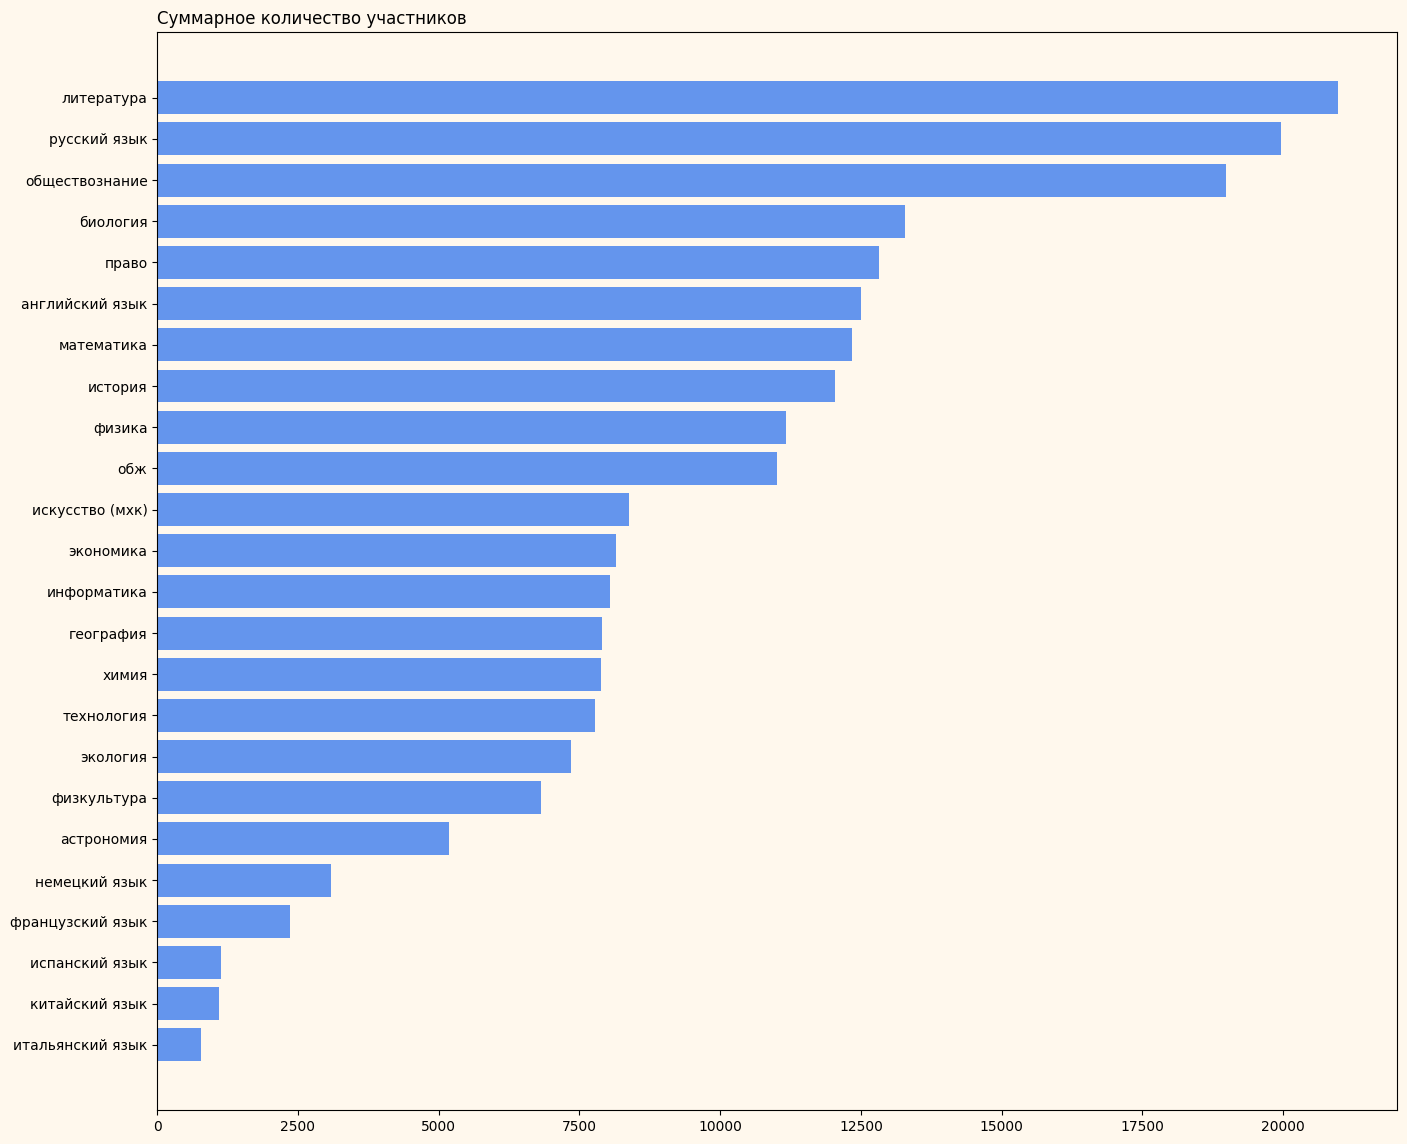

In [ ]:
fig, ax = plt.subplots(figsize=(16, 14))
backgroundcolor = '#FFF8ED'
subject_counts = df['предмет'].value_counts()[::-1]
plt.barh(subject_counts.index, subject_counts, color='cornflowerblue')

fig.set_facecolor(backgroundcolor)
ax.set_facecolor(backgroundcolor)
ax.set_title("Суммарное количество участников", loc='left')
plt.xlabel("")
plt.ylabel("")
plt.show()

Сводная таблица. Обратите внимание, что для графика корреляций нужно указывать какой-то один год, иначе рискуем получить biased результаты за счет школьников, участвующих в олимпидах из года в год. В свобдной таблице они из-за класса будут считаться разными записями, хотя по факту это один человек.

In [ ]:
def get_year_with_max_records(df):
    return df['год'].value_counts().index[0]


def get_students_subjects_pivotted_table(df, subjects=None, grades=None, fios=None,
                                         results=None, regions=None, years=None, levels=None,
                                         result_mapping={'участник': 1, 'призер': 2, 'победитель': 3}):  # это всё должны быть списки с именами значений или None, если нужны все
    assert all(df.columns == ['предмет', 'класс', 'фио', 'результат',
                              'административная_единица', 'год', 'уровень_олимпиады'])

    conditions = {
        'предмет': subjects,
        'класс': grades,
        'фио': fios,
        'результат': results,
        'административная_единица': regions,
        'год': years,
        'уровень_олимпиады': levels
    }

    new_df = df.copy()

    for col, col_values in conditions.items():
        if col_values is not None:
            new_df = new_df[new_df[col].isin(col_values)]

    new_df['результат_число'] = new_df['результат'].map(result_mapping)
    new_df['уникальное_имя'] = (
        new_df['класс'].astype(str) + new_df['фио'] +
        new_df['административная_единица'] + new_df['год'].astype(str)
    )  # .apply(hash) хэш можно убрать, если захочется посмотреть фио

    pivotted = new_df.pivot_table(
        index='уникальное_имя', columns='предмет',
        values='результат_число', aggfunc='sum', fill_value=0
    )

    return pivotted

In [ ]:
pivotted_df = get_students_subjects_pivotted_table(df, years=[get_year_with_max_records(df)])

График корреляций (косинусное сходство).

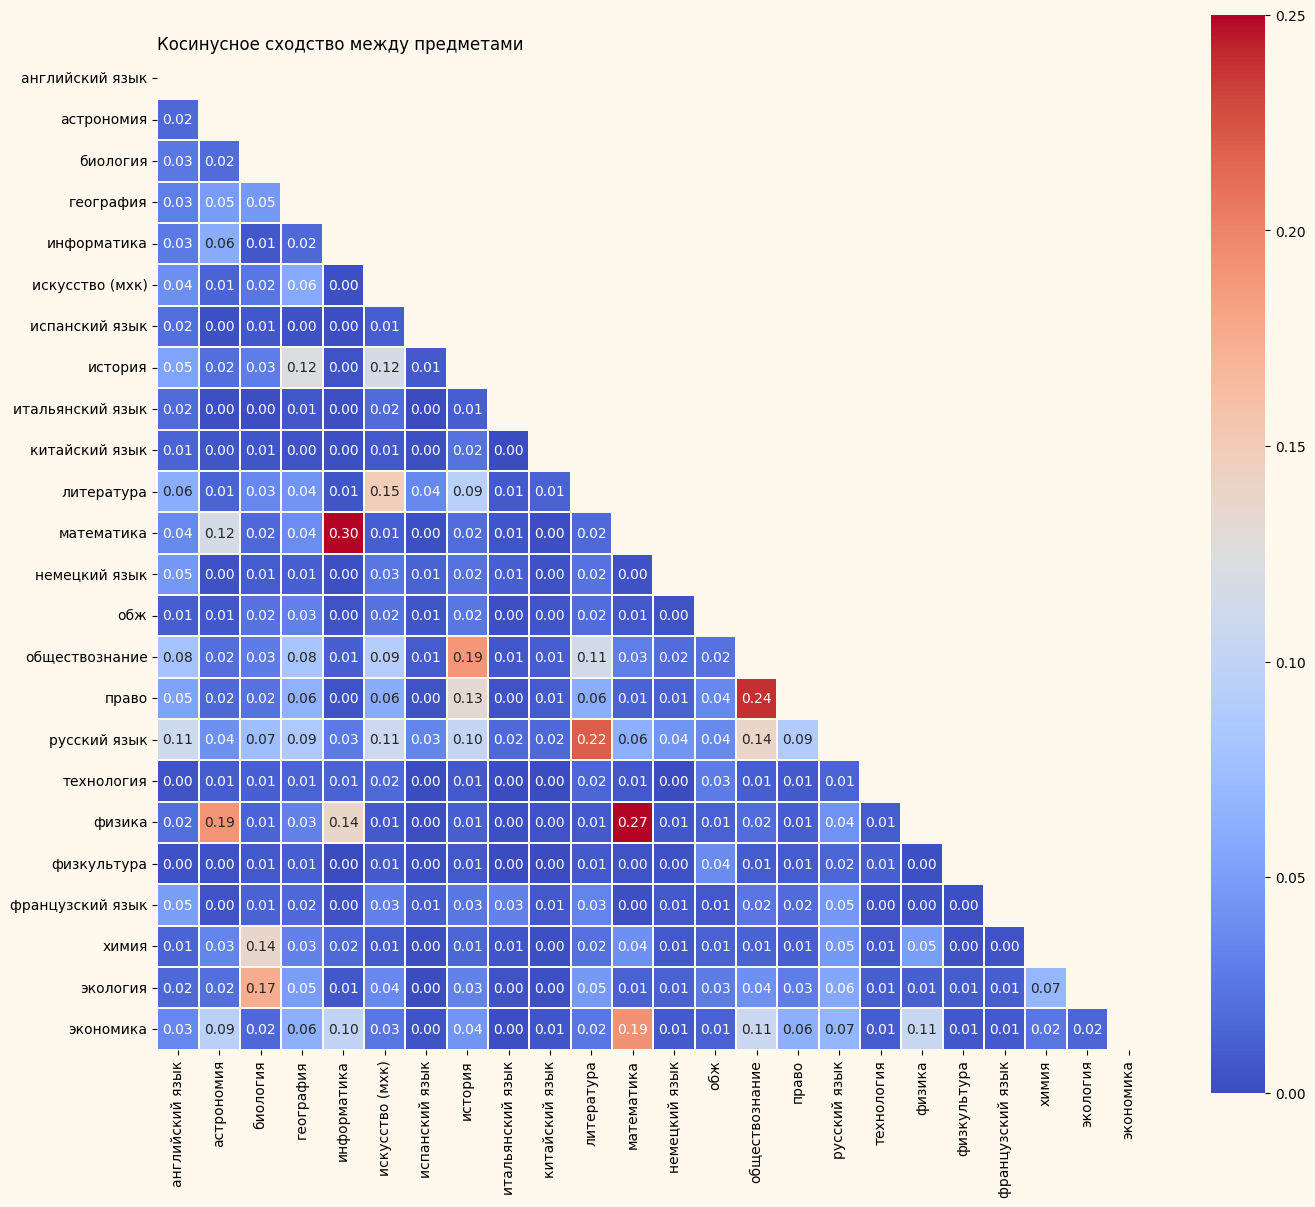

In [ ]:
fig, ax = plt.subplots(figsize=(16, 14))
backgroundcolor = '#FFF8ED'

cosine_sim_matrix = cosine_similarity(pivotted_df.T)

cosine_sim_df = pd.DataFrame(cosine_sim_matrix, columns=pivotted_df.columns, index=pivotted_df.columns)

upper_triangle_mask = np.triu(np.ones_like(cosine_sim_df, dtype=bool))

sns.heatmap(cosine_sim_df, mask=upper_triangle_mask, cmap="coolwarm", annot=True,
            fmt=".2f", linewidth=.3, linecolor=backgroundcolor, square=True,
            xticklabels=pivotted_df.columns, yticklabels=pivotted_df.columns, ax=ax,
            vmin=0, vmax=0.25)

fig.set_facecolor(backgroundcolor)
ax.set_facecolor(backgroundcolor)
ax.set_title("Косинусное сходство между предметами", loc='left')
plt.xlabel("")
plt.ylabel("")
plt.xticks(rotation=90)
plt.show()

Кластеризация.

In [ ]:
df_to_clust = pivotted_df.T

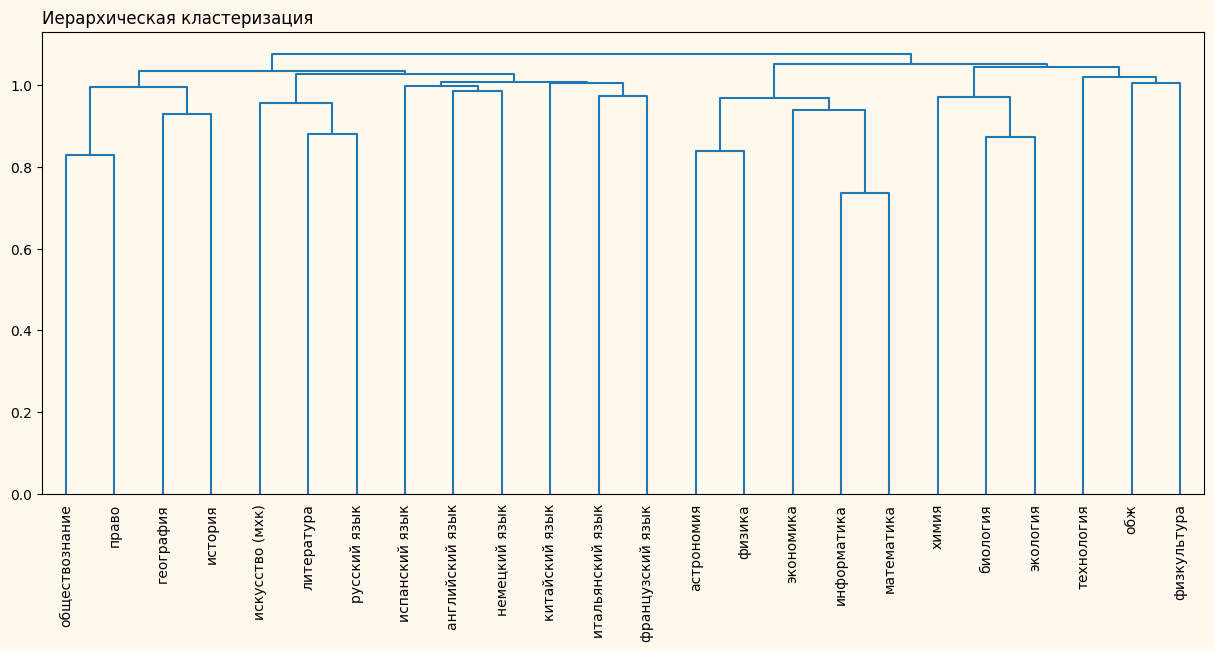

In [ ]:
linkage_matrix = linkage(df_to_clust.values, method='complete', metric='correlation')  # методы, на которые стоит посмотреть: correlation, cosine
fig, ax = plt.subplots(figsize=(15, 6))
dendrogram(linkage_matrix, labels=df_to_clust.index, orientation='top', color_threshold=0)
fig.set_facecolor(backgroundcolor)
ax.set_title('Иерархическая кластеризация', loc='left')
ax.set_facecolor(backgroundcolor)
plt.xlabel("")
plt.ylabel("")
plt.xticks(rotation=90)
plt.show()

В скольких предметах человек занял места.

In [ ]:
pivotted_df['колво_предметов'] = pivotted_df.apply(lambda row: len(row[row != 0]), axis=1)
pivotted_df['колво_предметов'].describe()

count    11710.000000
mean         1.353032
std          0.764451
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         10.000000
Name: колво_предметов, dtype: float64

Страшные люди. Некоторые из них даже гуглятся!

In [ ]:
pivotted_df[pivotted_df['колво_предметов'] == 10]

предмет,английский язык,астрономия,биология,география,информатика,искусство (мхк),испанский язык,история,итальянский язык,китайский язык,...,право,русский язык,технология,физика,физкультура,французский язык,химия,экология,экономика,колво_предметов
уникальное_имя,,,,,,,,,,,,,,,,,,,,,
9Коршунова А.И.г. Москва2022,0,0,2,1,0,0,0,2,0,0,...,3,1,0,1,0,0,2,1,0,10
9Мусаев М.Ш.г. Москва2022,0,1,1,1,0,0,0,0,0,0,...,1,1,0,1,0,0,1,1,1,10


## Не вошедшее в итоговую работу

In [ ]:
df = pd.read_csv("100124.csv", sep=',')

df = df[df.columns[:list(df.columns).index('Unnamed: 8')]]
df = df.drop(df.index[df['фио'].isna()])
df = df[['класс','предмет','фио']]
to_drop = ['китайский язык', 'итальянский язык', 'испанский язык', 'французский язык', 'физкультура']
df = df[~df['предмет'].isin(to_drop)]

colors = mcolors.CSS4_COLORS

In [ ]:
desired_order = [
    'английский язык',
    'немецкий язык',
    'русский язык',
    'литература',
    'обществознание',
    'право',
    'история',
    'математика',
    'физика',
    'информатика',
    'экономика',
    'биология',
    'химия',
    'география',
    'экология',
    'астрономия',
    'технология',
    'искусство (мхк)',
    'обж'
    ]

df['предмет'] = pd.Categorical(df['предмет'], categories=desired_order, ordered=True)
df = df.sort_values('предмет')

In [ ]:
languages = ['английский язык', 'немецкий язык']
humanitarian = ['русский язык', 'литература', 'обществознание', 'право', 'история']
maths = ['математика', 'физика', 'информатика', 'экономика']
bio = ['биология', 'химия', 'география', 'экология', 'астрономия']
app_science = ['технология', 'искусство (мхк)', 'обж']

colors_scheme = {
    'английский язык': colors['blueviolet'],
    'немецкий язык': colors['indigo'],
    'русский язык': colors['deepskyblue'],
    'литература': colors['dodgerblue'],
    'обществознание': colors['skyblue'],
    'право': colors['cornflowerblue'],
    'история': colors['darkturquoise'],
    'математика': colors['tomato'],
    'физика': colors['coral'],
    'информатика': colors['red'],
    'экономика': colors['orangered'],
    'биология': colors['springgreen'],
    'химия': colors['mediumspringgreen'],
    'география': colors['darkseagreen'],
    'экология': colors['forestgreen'],
    'астрономия': colors['teal'],
    'технология': colors['darkkhaki'],
    'искусство (мхк)': colors['goldenrod'],
    'обж': colors['tan']
}

In [ ]:
subjects = list(df['предмет'].unique())
subjects = {sub: subjects.index(sub) + 1 for sub in subjects}
subjects

{'английский язык': 1,
 'немецкий язык': 2,
 'русский язык': 3,
 'литература': 4,
 'обществознание': 5,
 'право': 6,
 'история': 7,
 'математика': 8,
 'физика': 9,
 'информатика': 10,
 'экономика': 11,
 'биология': 12,
 'химия': 13,
 'география': 14,
 'экология': 15,
 'астрономия': 16,
 'технология': 17,
 'искусство (мхк)': 18,
 'обж': 19}

In [ ]:
subjects_list = list(df['предмет'].unique())
subjects_list

['английский язык',
 'немецкий язык',
 'русский язык',
 'литература',
 'обществознание',
 'право',
 'история',
 'математика',
 'физика',
 'информатика',
 'экономика',
 'биология',
 'химия',
 'география',
 'экология',
 'астрономия',
 'технология',
 'искусство (мхк)',
 'обж']

In [ ]:
MAX_LINE_SIZE = 4

2 класса

In [ ]:
classes = [9, 11]

In [ ]:
df_classes = [df[df['класс'] == i].drop_duplicates() for i in classes[:2]]
df_classes = [df_classes[i].pivot(index='фио', columns='предмет', values='класс') for i in range(2)]
df_class = df_classes[0].join(df_classes[1], on='фио', lsuffix=str(classes[0]), rsuffix=str(classes[1]), how='inner')

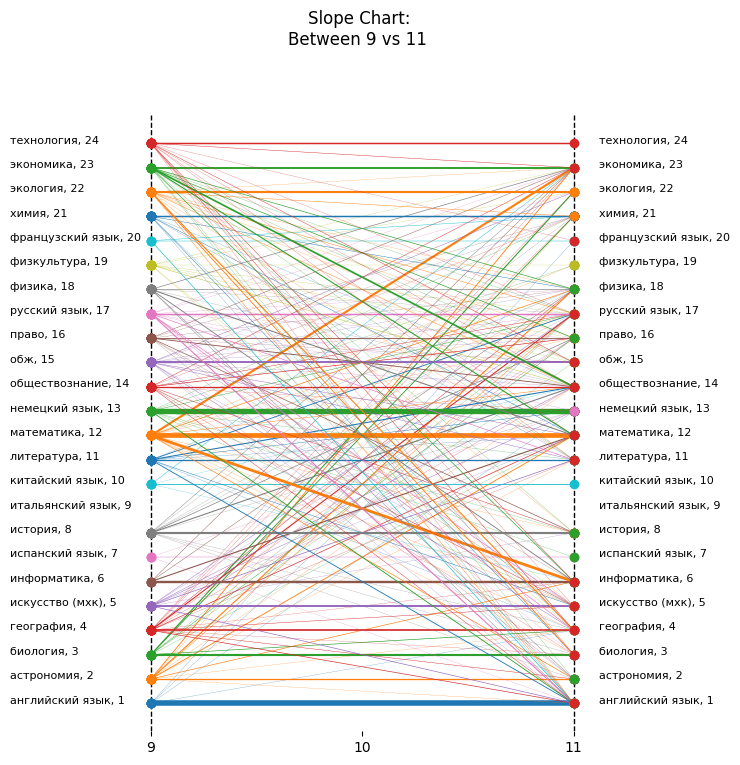

In [ ]:
plt.figure(figsize=(6, 8))

plt.axvline(x=classes[0], color='black', linestyle='--', linewidth=1) # 1952
plt.axvline(x=classes[1], color='black', linestyle='--', linewidth=1) # 1957

num_peoples = {}
for subject_old in subjects:
  col_old = subject_old + str(classes[0])
  values = df_class[df_class[col_old].notna()]

  for subject_new in subjects:
    col_new = subject_new + str(classes[1])
    num_people = len(values[values[col_new].notna()].index)

    if num_people > 0:
      num_peoples[(subjects[subject_old], subjects[subject_new])] = num_people

coef = max(num_peoples.values()) / 4

for line, num_people in num_peoples.items():
  col = subject_colors[(line[0] - 1) % len(subject_colors)]
  plt.plot(classes, line, marker='o', linewidth=num_people / coef, c=col)


for subject, ind in subjects.items():
  for cl in classes:
    if cl==classes[0]:
      x_position = cl - (classes[1] - classes[0]) / 3
    else:
      x_position = cl + 0.12

    plt.text(x_position, ind, f'{subject}, {ind}', fontsize=8, color='black')


plt.title(f'Slope Chart: \nBetween {classes[0]} vs {classes[1]}  \n\n\n')
plt.yticks([])
plt.xticks(range(classes[0], classes[1] + 1))
plt.box(False)
plt.show()

3 класса

In [ ]:
classes = [9, 10, 11]

In [ ]:
def get_classes(classes):
  df_classes = [df[df['класс'] == i].drop_duplicates() for i in classes[:2]]
  df_classes = [df_classes[i].pivot(index='фио', columns='предмет', values='класс') for i in range(2)]
  df_class = df_classes[0].join(df_classes[1], on='фио', lsuffix=str(classes[0]), rsuffix=str(classes[1]), how='inner')
  print(classes, '-', df_class.shape)
  df_class.head()
  return df_class


In [ ]:
df_class_1 = get_classes(classes[:2])
df_class_2 = get_classes(classes[1:])

[9, 10] - (1295, 38)
[10, 11] - (1458, 38)


In [ ]:
def hanging_line(point1, point2, f):
    a = (point2[1] - point1[1])/(f(point2[0]) - f(point1[0]))
    b = point1[1] - a*f(point1[0])
    x = np.linspace(point1[0], point2[0], 100)
    y = a*f(x) + b
    return (x,y)

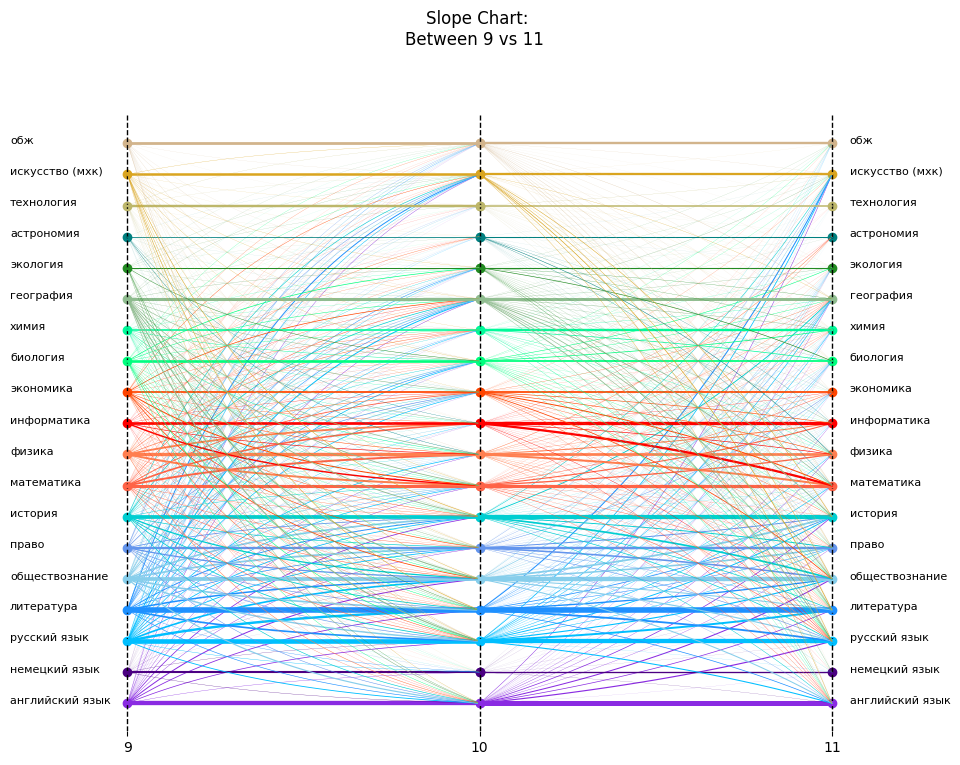

In [ ]:
plt.figure(figsize=(10, 8))

for cl in classes:
  plt.axvline(x=cl, color='black', linestyle='--', linewidth=1)


def plot_class(df_class, classes, fun):
  num_peoples = {}
  for subject_old in subjects:

    col_old = subject_old + str(classes[0])
    values = df_class[df_class[col_old].notna()]

    for subject_new in subjects:
      col_new = subject_new + str(classes[1])
      num_people = len(values[values[col_new].notna()].index)

      if num_people > 0:
        num_peoples[(subjects[subject_old], subjects[subject_new])] = num_people

  coef = max(num_peoples.values()) / MAX_LINE_SIZE

  for line, num_people in num_peoples.items():
    sub = subjects_list[line[0] - 1]
    col = colors_scheme[sub]
    plt.plot(*hanging_line(*zip(classes, line), f=fun), linestyle='-', linewidth=num_people / coef, c=col)

  for subject in subjects.values():
    for cl in classes:
      sub = subjects_list[subject - 1]
      col = colors_scheme[sub]
      plt.scatter(cl, subject, c=col)

plot_class(df_class_1, classes[:2], np.tanh)
plot_class(df_class_2, classes[1:], np.cosh)

for subject, ind in subjects.items():
  for cl in [classes[0], classes[-1]]:
    if cl==classes[0]:
      x_position = cl - (classes[1] - classes[0]) / 3
    else:
      x_position = cl + 0.05

    plt.text(x_position, ind, f'{subject}', fontsize=8, color='black')


plt.title(f'Slope Chart: \nBetween {classes[0]} vs {classes[-1]}  \n\n\n')
plt.yticks([])
plt.xticks(range(classes[0], classes[-1] + 1))
plt.box(False)
plt.show()